In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
sns.set_theme(style="darkgrid")

# Single Plot

In [2]:
file_path = "acquisitions/consumption/4_2V-5_30Hz.csv"
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe to understand its structure
data.head()

,Index,Reading,Unit,Range Digits,Disp Digits,Math,Start Group,Limit1 High,Limit1 Low,Limit2 High,...,Value,Unit.1,Digits,Output,Sense,Source Limit,Overtemp,Date,Time,Fractional Seconds
0,1,0.009229,Amp DC,0.1,6.5,F,F,F,F,F,...,4.196816,Volt DC,10,T,2W,F,F,02/29/2024,18:56:48,0.797757
1,2,0.009977,Amp DC,0.1,6.5,F,F,F,F,F,...,4.196322,Volt DC,10,T,2W,F,F,02/29/2024,18:56:48,0.801209
2,3,0.007420,Amp DC,0.1,6.5,F,F,F,F,F,...,4.194894,Volt DC,10,T,2W,F,F,02/29/2024,18:56:48,0.804625
3,4,0.007020,Amp DC,0.1,6.5,F,F,F,F,F,...,4.199198,Volt DC,10,T,2W,F,F,02/29/2024,18:56:48,0.808060
4,5,0.007231,Amp DC,0.1,6.5,F,F,F,F,F,...,4.204560,Volt DC,10,T,2W,F,F,02/29/2024,18:56:48,0.811472


In [3]:
# Keeping only the necessary columns and merging 'Time' and 'Fractional Seconds'
data_cleaned = data[['Reading', 'Value', 'Date', 'Time', 'Fractional Seconds']].copy()

# Merging 'Time' and 'Fractional Seconds' into a single 'DateTime' column
# The fractional seconds will be added as milliseconds to the 'Time' column
data_cleaned['DateTime'] = pd.to_datetime(data_cleaned['Date'] + ' ' + data_cleaned['Time']) + pd.to_timedelta(data_cleaned['Fractional Seconds'], unit='s')

# Dropping the original 'Date', 'Time', and 'Fractional Seconds' columns as they are now merged into 'DateTime'
data_cleaned.drop(['Date', 'Time', 'Fractional Seconds'], axis=1, inplace=True)
# Converting current from Amperes to milliamperes (mA)
data_cleaned['Reading'] = data_cleaned['Reading'] * 1000
# Displaying the updated DataFrame to ensure correctness
data_cleaned.head()


,Reading,Value,DateTime
0,9.229477,4.196816,2024-02-29 18:56:48.797756980
1,9.976921,4.196322,2024-02-29 18:56:48.801209020
2,7.419589,4.194894,2024-02-29 18:56:48.804625440
3,7.019902,4.199198,2024-02-29 18:56:48.808060180
4,7.230531,4.204560,2024-02-29 18:56:48.811471700


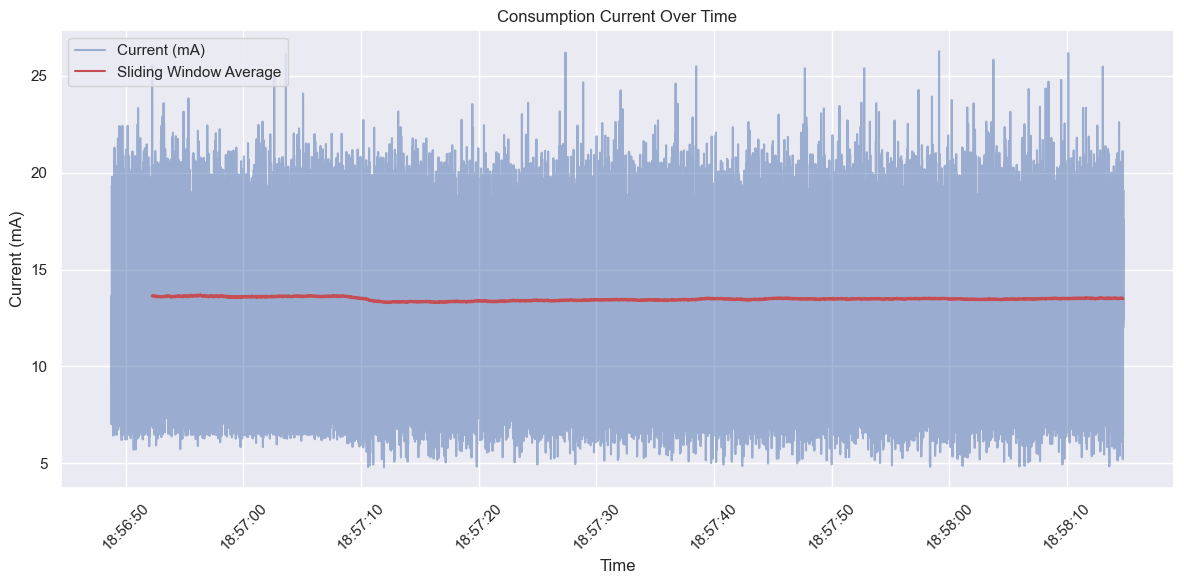

In [11]:
# Calculating a sliding window average (rolling mean) with a window size of 10
window_size = 1000
data_cleaned['Rolling Mean'] = data_cleaned['Reading'].rolling(window=window_size).mean()

# Creating the plot with seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_cleaned, x='DateTime', y='Reading', label='Current (mA)', color='C0', alpha=0.5)
sns.lineplot(data=data_cleaned, x='DateTime', y='Rolling Mean', label='Sliding Window Average', color='C3')

plt.title('Consumption Current Over Time')
plt.xlabel('Time')
plt.ylabel('Current (mA)')
plt.legend()

# Rotate date labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to make room for the rotated date labels

plt.show()


# Combined Plot

In [3]:
# Loading the three new CSV files for different voltage levels
file_paths = {
    '3.7V': 'acquisitions/consumption/3_7V-5_30Hz.csv',
    '4V': 'acquisitions/consumption/4V-5_30Hz.csv',
    '4.2V': 'acquisitions/consumption/4_2V-5_30Hz.csv'
}

# Creating a dictionary to hold the dataframes
dfs = {}

for voltage, path in file_paths.items():
    df = pd.read_csv(path)
    # Selecting and renaming the necessary columns
    df_cleaned = df[['Reading', 'Value', 'Date', 'Time', 'Fractional Seconds']].copy()
    df_cleaned['DateTime'] = pd.to_datetime(df_cleaned['Date'] + ' ' + df_cleaned['Time']) + pd.to_timedelta(df_cleaned['Fractional Seconds'], unit='s')
    df_cleaned.drop(['Date', 'Time', 'Fractional Seconds'], axis=1, inplace=True)
    df_cleaned['Reading_mA'] = df_cleaned['Reading'] * 1000  # Convert current to mA
    df_cleaned['Voltage'] = voltage  # Add voltage level as a column
    dfs[voltage] = df_cleaned

dfs['3.7V'] = dfs['3.7V'].iloc[4000:].reset_index(drop=True)
dfs['4.2V'] = dfs['4.2V'].iloc[4200:].reset_index(drop=True)
# Combining the dataframes into one for comparison
combined_df = pd.concat(dfs.values())

# Displaying the first few rows of the combined dataframe
combined_df.head()

,Reading,Value,DateTime,Reading_mA,Voltage
0,0.016035,3.705546,2024-02-29 19:25:04.775774360,16.035488,3.7V
1,0.014974,3.698556,2024-02-29 19:25:04.779184600,14.974345,3.7V
2,0.015447,3.699592,2024-02-29 19:25:04.782594660,15.446989,3.7V
3,0.015768,3.697721,2024-02-29 19:25:04.786029700,15.767563,3.7V
4,0.017486,3.699277,2024-02-29 19:25:04.789450640,17.486168,3.7V


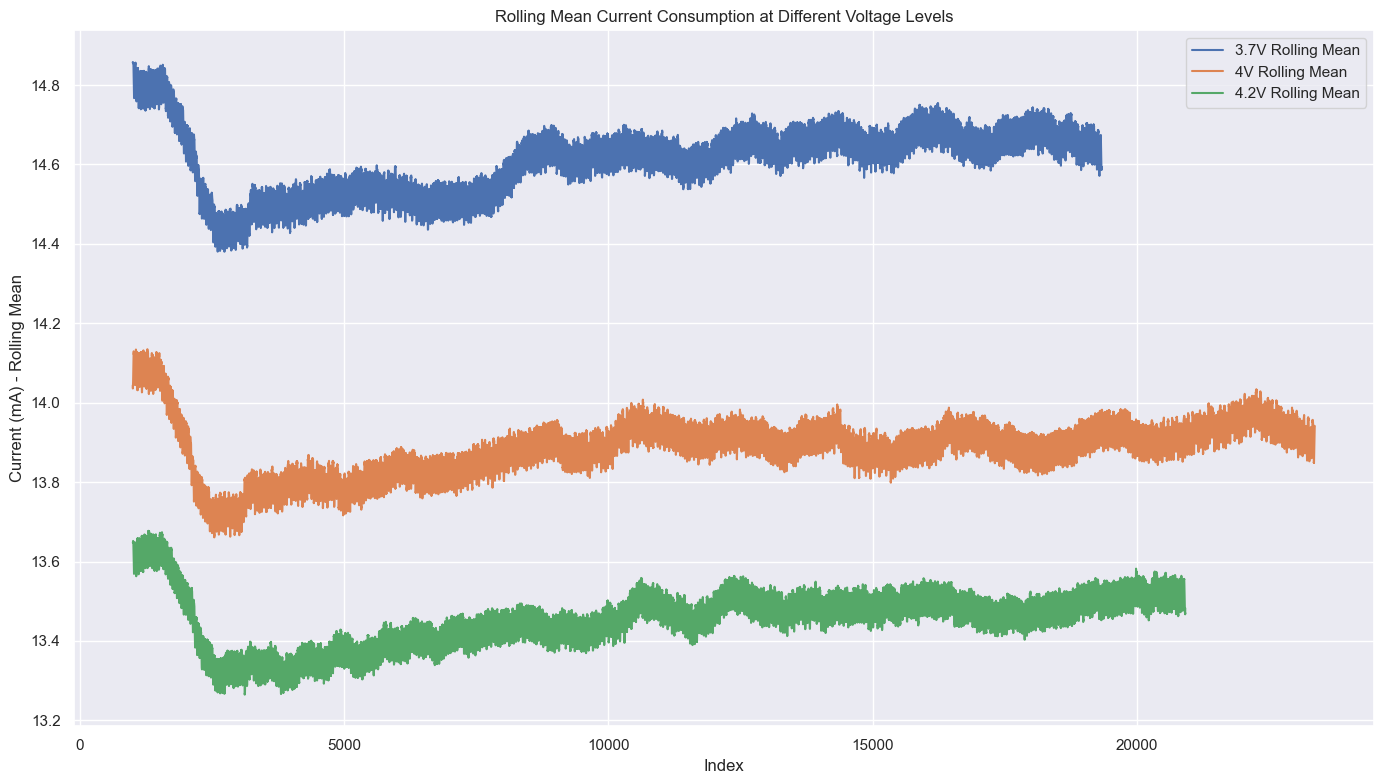

In [4]:
# Calculating rolling mean for each voltage level within the combined dataframe
window_size = 1000
combined_df['Rolling Mean_mA'] = combined_df.groupby('Voltage')['Reading_mA'].transform(lambda x: x.rolling(window=window_size).mean())

# Plotting the rolling mean of current (mA) for each voltage level
plt.figure(figsize=(14, 8))

# Plotting each voltage level separately
for voltage in combined_df['Voltage'].unique():
    subset = combined_df[combined_df['Voltage'] == voltage]
    plt.plot(subset.index, subset['Rolling Mean_mA'], label=f'{voltage} Rolling Mean')

plt.title('Rolling Mean Current Consumption at Different Voltage Levels')
plt.xlabel('Index')
plt.ylabel('Current (mA) - Rolling Mean')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

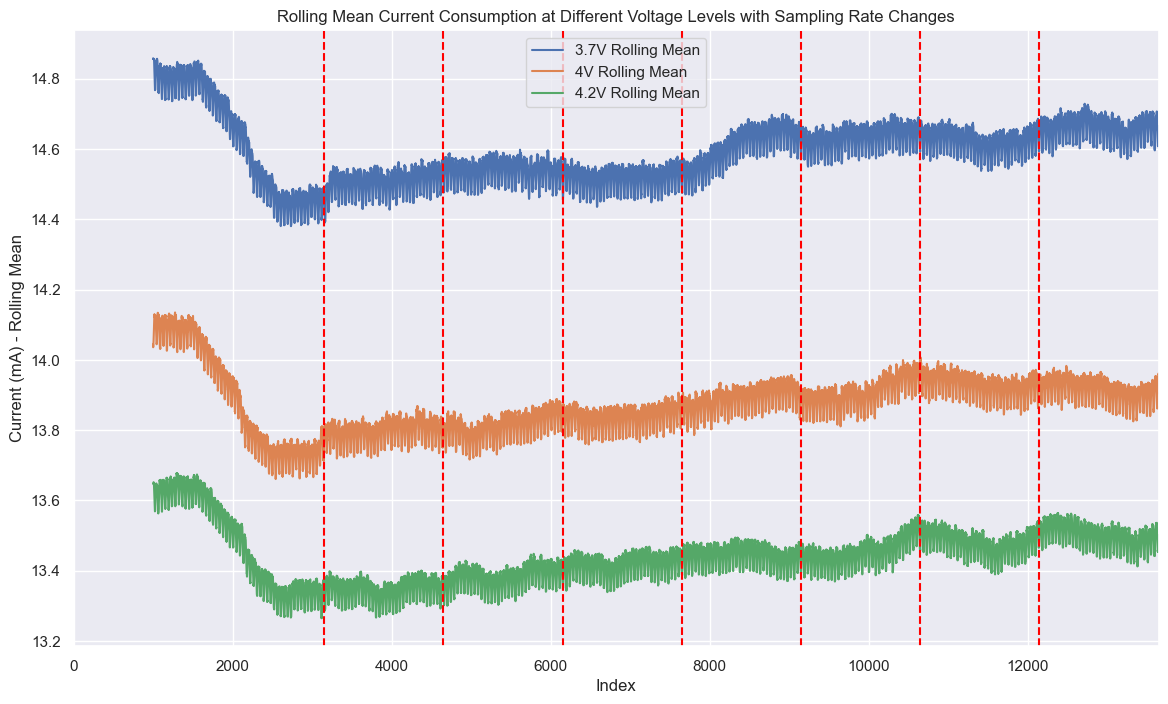

In [5]:
# Set the figure size
plt.figure(figsize=(14, 8))

# Plot the rolling mean for each voltage level
for voltage in combined_df['Voltage'].unique():
    subset = combined_df[combined_df['Voltage'] == voltage]
    plt.plot(subset.index, subset['Rolling Mean_mA'], label=f'{voltage} Rolling Mean')

# Calculate the index for every 5-second interval starting from index 3000
samples_per_second = 300
five_second_intervals = 5
start_index = 3150  # Starting index for the 5Hz change
change_intervals = [start_index + i * five_second_intervals * samples_per_second for i in range(7)]

# Draw vertical lines at each interval
for line_index in change_intervals:
    plt.axvline(x=line_index, color='red', linestyle='--')

# Trim the plot right after the seventh line, which is the last item in 'change_intervals'
trim_index = change_intervals[-1] + five_second_intervals * samples_per_second
plt.xlim(0, trim_index)

# Adding labels and title
plt.title('Rolling Mean Current Consumption at Different Voltage Levels with Sampling Rate Changes')
plt.xlabel('Index')
plt.ylabel('Current (mA) - Rolling Mean')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

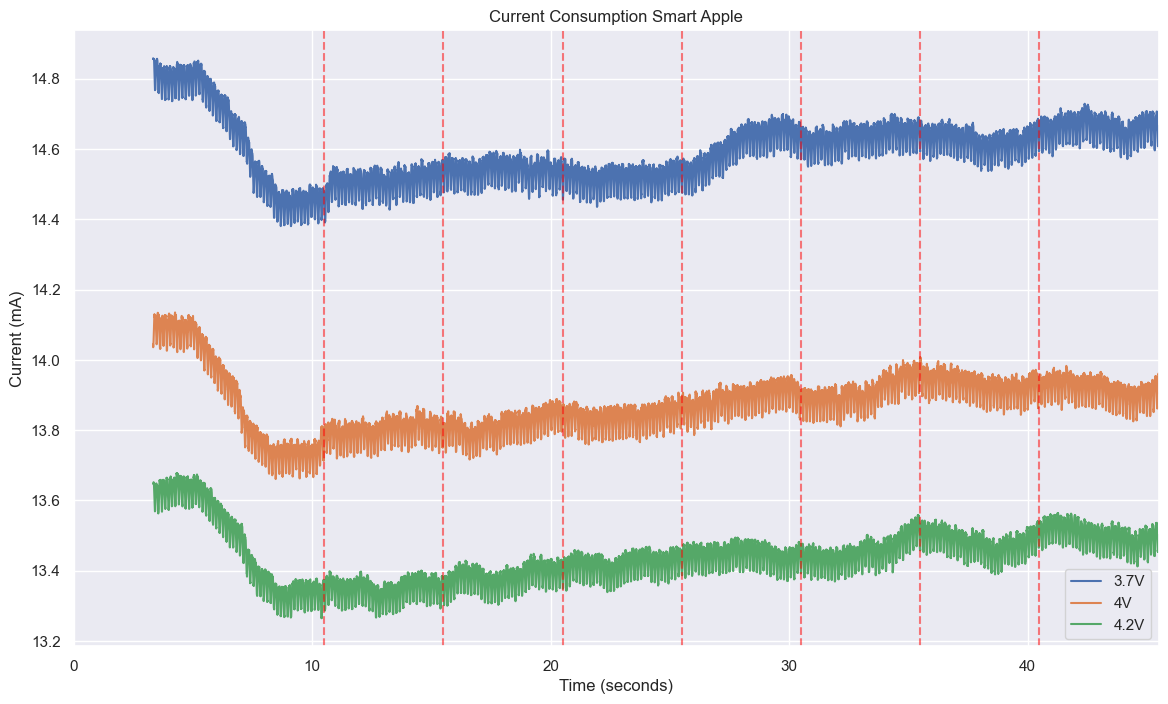

In [6]:
# Set the figure size
plt.figure(figsize=(14, 8))

# Calculate the time in seconds for each vertical line
time_intervals = [(start_index + i * five_second_intervals * samples_per_second) / samples_per_second for i in range(7)]

# Plot the rolling mean for each voltage level, converting index to time
for voltage in combined_df['Voltage'].unique():
    subset = combined_df[combined_df['Voltage'] == voltage]
    time_seconds = subset.index / samples_per_second  # Convert index to time in seconds
    plt.plot(time_seconds, subset['Rolling Mean_mA'], label=f'{voltage}')

# Draw vertical lines at each interval
for time_seconds_line in time_intervals:
    plt.axvline(x=time_seconds_line, color='red', linestyle='--', alpha=0.5)

# Trim the plot right after the seventh line
# The seventh interval is at index 6 since the count starts from 0
trim_time_seconds = time_intervals[6] + five_second_intervals
plt.xlim(0, trim_time_seconds)

# Adding labels and title
plt.title('Current Consumption Smart Apple')

plt.xlabel('Time (seconds)')
plt.ylabel('Current (mA)')
# move legend to the bottom right
plt.legend(loc='lower right')
plt.grid(True)

# Show the plot
plt.show()


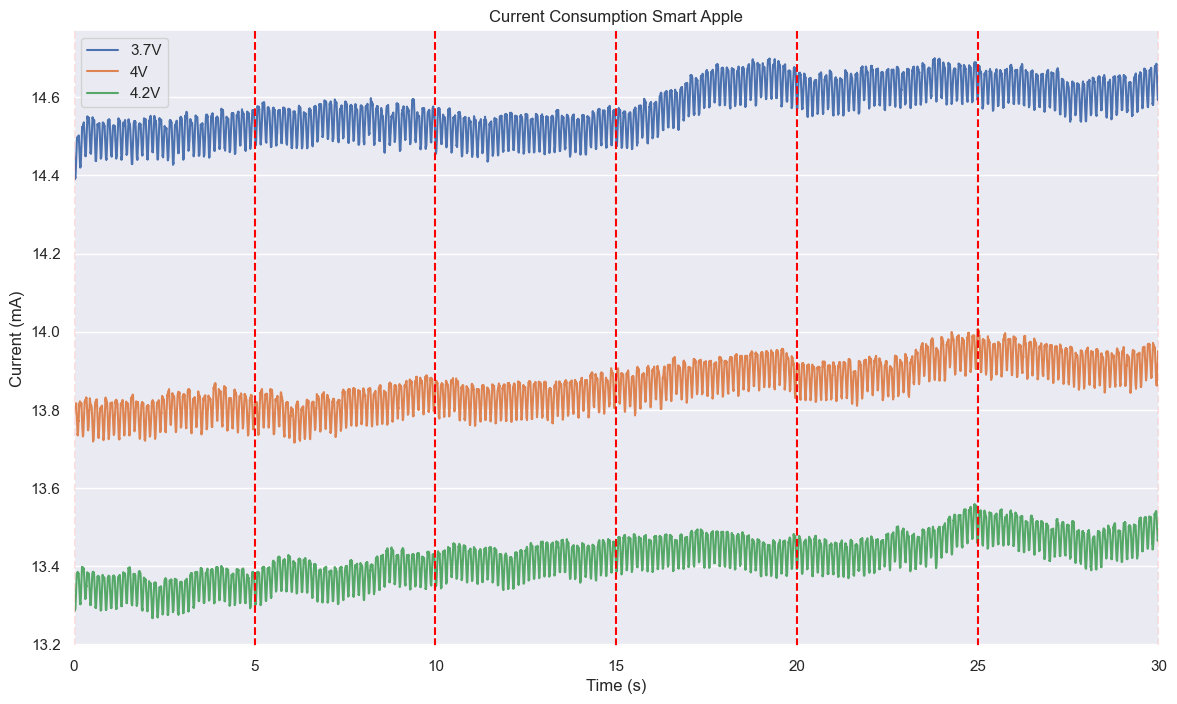

In [7]:
# Set up the figure and axes for the plot
fig, ax = plt.subplots(figsize=(14, 8))

# Calculate the rolling mean for each voltage level within the combined dataframe
window_size = 1000
for voltage, df in dfs.items():
    df['Rolling Mean_mA'] = df['Reading_mA'].rolling(window=window_size).mean()

# Adjust the start index and trim the data after the seventh change in the sampling rate
start_index = 3150  # Adjusted start index
samples_per_second = 300  # 300 samples per second
seconds_between_changes = 5  # Interval of sampling rate changes in seconds
change_intervals = np.arange(start_index, len(combined_df), samples_per_second * seconds_between_changes)

# Calculate the index to trim after the seventh change
trim_after = change_intervals[6]  # Index right after the seventh change

# Adjust indices and plot the rolling means
for voltage, df in dfs.items():
    # Adjust the index to start from zero
    df = df.iloc[start_index:trim_after].copy()
    df.reset_index(drop=True, inplace=True)
    df['Time (s)'] = df.index / samples_per_second  # Convert index to seconds
    ax.plot(df['Time (s)'], df['Rolling Mean_mA'], label=f'{voltage}')

# Draw vertical lines at each sampling rate change interval, up to the trim point
for line_index in change_intervals:
    if line_index <= trim_after:
        seconds = (line_index - start_index) / samples_per_second
        ax.axvline(x=seconds, color='red', linestyle='--')

# Set the limits for the x-axis to stop after the seventh line
ax.set_xlim(left=0, right=(change_intervals[6] - start_index) / samples_per_second)

# Add title and labels
ax.set_title('Current Consumption Smart Apple')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Current (mA)')
ax.legend()

# Show the plot
plt.show()


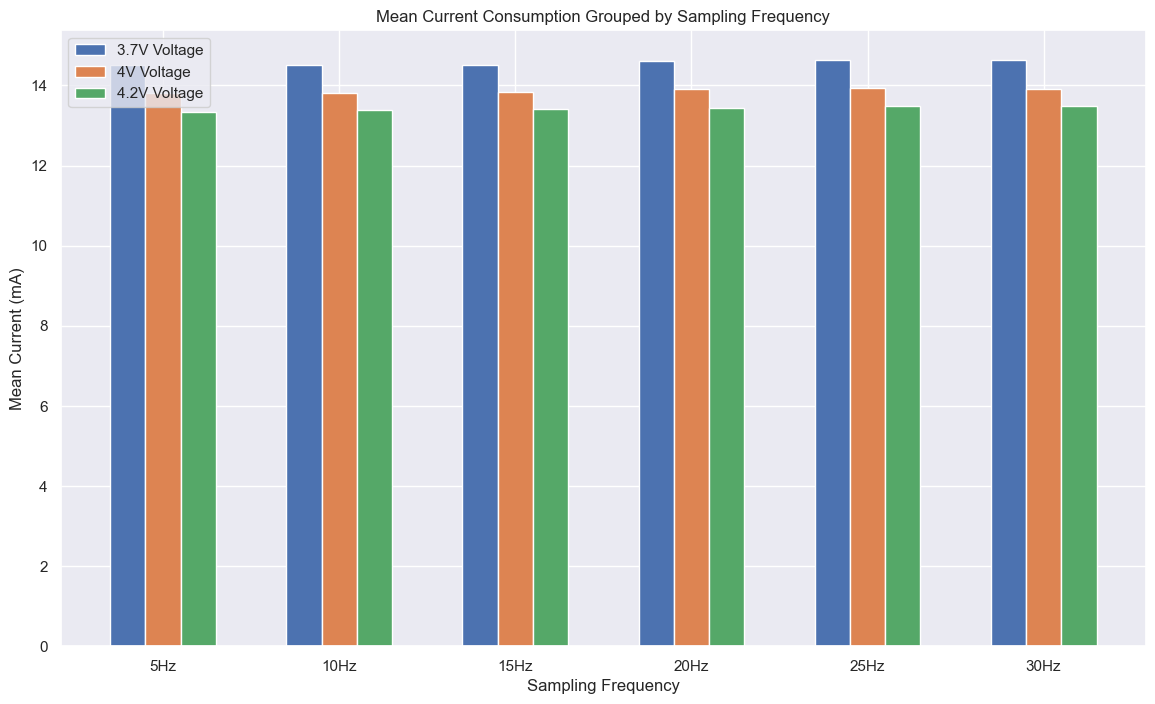

In [8]:
# Set up the figure for the histogram
fig, ax = plt.subplots(figsize=(14, 8))

# Define the bin edges for the histogram, corresponding to the sampling frequencies
# Each bin edge is the index where the sampling rate changes
bin_edges = change_intervals[:7]  # Only consider up to the seventh change (30Hz)

# Create a list of labels for the histogram bins, corresponding to the sampling frequencies
bin_labels = ['5Hz', '10Hz', '15Hz', '20Hz', '25Hz', '30Hz']

# Define a function to calculate the mean current for each bin
def mean_current_in_bin(df, bin_start, bin_end):
    """Calculate the mean current in the bin defined by bin_start and bin_end indices."""
    bin_df = df[(df.index >= bin_start) & (df.index < bin_end)]
    return bin_df['Reading_mA'].mean()

# Initialize a dictionary to hold the mean current for each bin and voltage level
hist_data = {label: [] for label in bin_labels}

# Calculate the mean current for each bin and voltage level
for i in range(len(bin_edges) - 1):
    for voltage, df in dfs.items():
        # Calculate the mean current in the current bin for the current voltage level
        mean_current = mean_current_in_bin(df, bin_edges[i], bin_edges[i+1])
        # Append the mean current to the corresponding list in the hist_data dictionary
        hist_data[bin_labels[i]].append(mean_current)

# Plot the histogram with grouped bars
bar_width = 0.2  # Width of the bars
# Set the positions of the bars for each group
positions = np.arange(len(bin_labels))

for i, (voltage_level, df) in enumerate(dfs.items()):
    # Calculate the mean currents for each bin for this voltage level
    means = [mean_current_in_bin(df, bin_edges[j], bin_edges[j+1]) for j in range(len(bin_edges) - 1)]
    # Plot the bars for this voltage level
    plt.bar(positions + i * bar_width, means, width=bar_width, label=f'{voltage_level} Voltage')

# Set the x-ticks to be in the center of each group of bars
ax.set_xticks(positions + bar_width)
# Set the x-tick labels to be the sampling frequencies
ax.set_xticklabels(bin_labels)

# Add title and labels
ax.set_title('Mean Current Consumption Grouped by Sampling Frequency')
ax.set_xlabel('Sampling Frequency')
ax.set_ylabel('Mean Current (mA)')
ax.legend()

# Show the plot
plt.show()



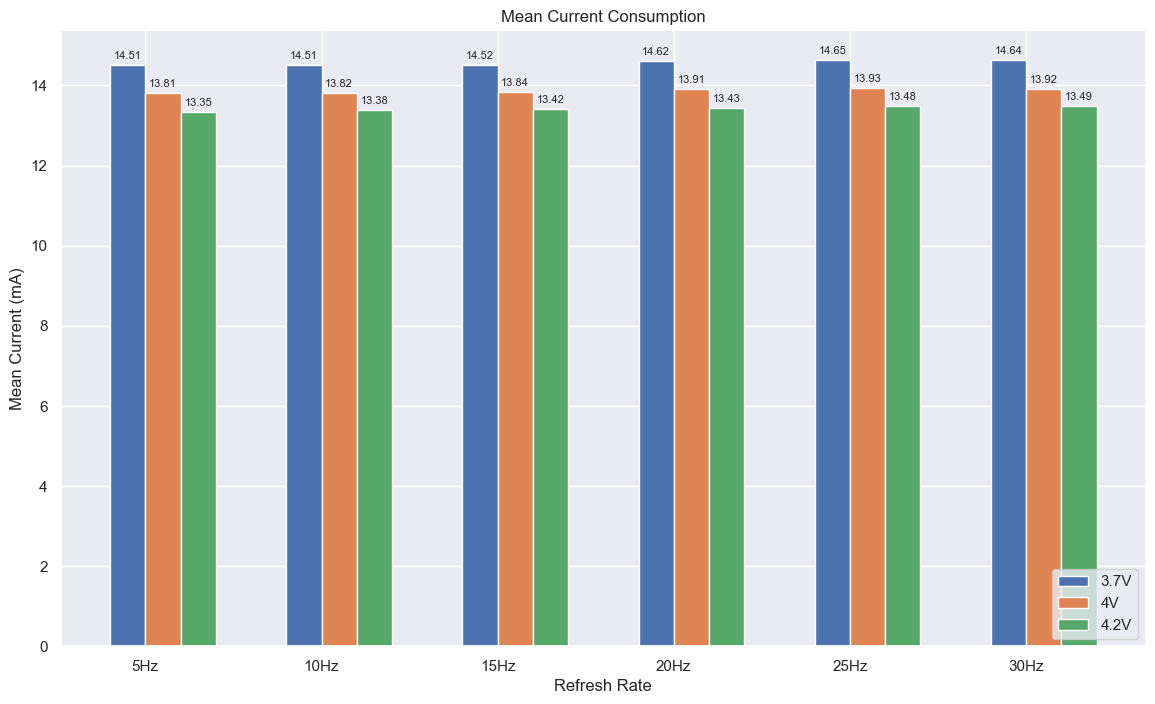

In [10]:
# Set up the figure for the histogram
fig, ax = plt.subplots(figsize=(14, 8))

# Define the positions for the groups of bars
positions = np.arange(len(bin_labels))

# We will need to store the mean currents for each voltage level and sampling frequency
mean_currents = {voltage: [] for voltage in dfs.keys()}

# Calculate the mean currents
for bin_start, bin_end in zip(bin_edges[:-1], bin_edges[1:]):
    for voltage, df in dfs.items():
        mean_current = mean_current_in_bin(df, bin_start, bin_end)
        mean_currents[voltage].append(mean_current)

# Plot the histogram with grouped bars
for i, (voltage, means) in enumerate(mean_currents.items()):
    # Offset the positions for each group to create grouped bar effect
    offset_positions = positions - bar_width + (i * bar_width)
    bars = ax.bar(offset_positions, means, width=bar_width, label=f'{voltage}')

    # Add the current value on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    fontsize=8,
                    ha='center', va='bottom')

# Set the x-ticks to be in the center of the group of bars
ax.set_xticks(positions - bar_width / 2)
# Set the x-tick labels to be the sampling frequencies
ax.set_xticklabels(bin_labels)

# Add title and labels
ax.set_title('Mean Current Consumption')
ax.set_xlabel('Refresh Rate')
ax.set_ylabel('Mean Current (mA)')
ax.legend(loc='lower right')

# Show the plot
plt.show()
